In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline

In [2]:
#https://en.wikipedia.org/wiki/Rosenbrock_function
def f(x):   # The rosenbrock function
    a = 1.0
    b = 100.0
    return (a - x[0])**2 + b*(x[1] - x[0]**2)**2

def derivate(x):
    a = 1.0
    b = 100.0
    return np.array((-2*a*(1 - x[0]) - 4*b*x[0]*(x[1] - x[0]**2), 2*b*(x[1] - x[0]**2)))

def hessian(x):
    a = 1.0
    b = 100.0
    return np.array([
        [2*a - 4*b*x[1] + 12*b*(x[0]**2), - 4*b*x[0]],
        [- 4*b*x[0], 2*b]
    ])

In [3]:
def manifold(function=f, grids=11):
    parameter_menifold={'params':[], 'responses':[]}
    space_range = 3.0
    for y in np.linspace(-space_range, space_range, num=grids):
        for x in np.linspace(-space_range, space_range, num=grids):
            parameter_menifold['params'].append( (x, y) )
            parameter_menifold['responses'].append( function([x, y]) )
            
    x = np.array(parameter_menifold['params'])[:, 0].reshape(grids, grids)
    y = np.array(parameter_menifold['params'])[:, 1].reshape(grids, grids)
    z = np.array(parameter_menifold['responses']).reshape(grids, grids)
    parameter_menifold['surface'] = (x, y, z)
    return parameter_menifold

In [4]:
def draw(fig, parameter_menifold, sub_grids=[1,1], index=1, points=[], grids=[], projection='2d'):
    x = parameter_menifold['surface'][0]
    y = parameter_menifold['surface'][1]
    z = parameter_menifold['surface'][2]
    
    class MidpointNormalize(colors.Normalize):
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            # I'm ignoring masked values and all kinds of edge cases to make a
            # simple example...
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y))
    
    if projection == '2d':
        ax = fig.add_subplot(sub_grids[1], sub_grids[0], index)
        surf = ax.contourf(x, y, z, 300,
#                           norm=MidpointNormalize(midpoint=5.0),
                           cmap=cm.coolwarm)
        for point, grad in zip(points, grids):
            ax.scatter([point[0]], [point[1]], linewidths=5, c='y', marker='^')
            if not grad is None:
                ax.arrow( point[0], point[1], -grad[0], -grad[1],
                         head_width=0.1, head_length=0.1, fc='k', ec='k')
    elif projection == '3d':
        ax = fig.add_subplot(sub_grids[1], sub_grids[0], index, projection='3d')

        surf = ax.plot_surface(x, -y, z,
                               cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=.75)
        for point, grad in zip(points, grids):
            ax.scatter([point[0]], [-point[1]], [point[2]], linewidths=5, c='y', marker='^')
#        ax.set_zlim(0.0, 20.0)

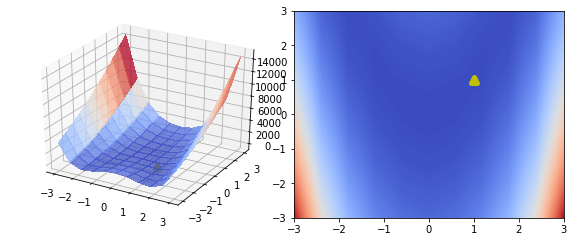

In [5]:
grids = [2, 1]
fig = plt.figure(figsize=(grids[0]*4, grids[1]*3))
fig.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

parameter_menifold = manifold()

draw(fig, parameter_menifold, sub_grids=grids, index=1, projection='3d', points=[(1.0, 1.0, 0)], grids=[None, ])
draw(fig, parameter_menifold, sub_grids=grids, index=2, projection='2d', points=[(1.0, 1.0, 0)], grids=[None, ])

In [6]:
x = np.array([-2.0, -2.0])
learning_rate = 0.0001

steps = []

g_prev, g_curr = None, None
pk = None
for i in range(3000):
    r = f(x)
    g_curr = derivate(x)
    if g_prev is None or pk is None:
        bk = 0.0
        pk = g_curr
    else:
        bk = np.clip(np.dot(g_curr, g_curr) / np.dot(g_prev, g_prev), -10.0, +10.0)
        #print(bk, np.dot(g_curr, g_curr), np.dot(g_prev, g_prev))
        
    norm = np.linalg.norm(g_curr)
    
    pk = - g_curr + bk * pk
    pk = norm / np.linalg.norm(pk) * pk
    
    g_prev = g_curr
    
    ak = learning_rate # TODO: we need to be more precise the choice of line search parameter ak (step length)
    delta = - ak * pk
    steps.append( {'param':x.tolist()+[r], 'gradient':delta} )
    x = x - delta


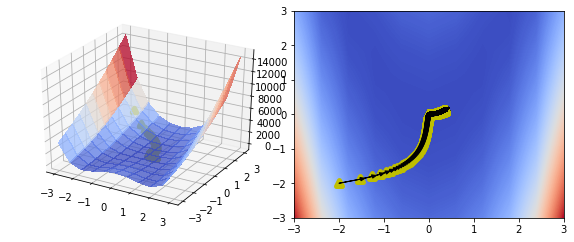

In [7]:
grids = [2, 1]
fig = plt.figure(figsize=(grids[0]*4, grids[1]*3))
fig.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

draw(fig, parameter_menifold, sub_grids=grids, index=1, projection='3d',
     points=[s['param'] for s in steps], grids=[s['gradient'] for s in steps])
draw(fig, parameter_menifold, sub_grids=grids, index=2, projection='2d',
     points=[s['param'] for s in steps], grids=[s['gradient'] for s in steps])

In [8]:
x, r

(array([ 0.37015702,  0.13399735]), 0.39771607053380093)